<a href="https://colab.research.google.com/github/benstaf/FinRL_DeepSeek/blob/main/FinRL_DeepSeek_backtest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FinRL-DeepSeek. Backtest


# Part 1. Install Packages

#Download environments: https://github.com/benstaf/FinRL_DeepSeek
#And trading agents: https://huggingface.co/benstaf/Trading_agents

In [1]:
#cd FinRL_LLM

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3

from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.config import INDICATORS, TRAINED_MODEL_DIR
from env_stocktrading import StockTradingEnv


# Import PPO-DeepSeek environments
from env_stocktrading_llm import StockTradingEnv as StockTradingEnv_llm
from env_stocktrading_llm_1 import StockTradingEnv as StockTradingEnv_llm_1
from env_stocktrading_llm_01 import StockTradingEnv as StockTradingEnv_llm_01

# Import CPPO-DeepSeek risk environments
from env_stocktrading_llm_risk import StockTradingEnv as StockTradingEnv_llm_risk
from env_stocktrading_llm_risk_1 import StockTradingEnv as StockTradingEnv_llm_risk_1
from env_stocktrading_llm_risk_01 import StockTradingEnv as StockTradingEnv_llm_risk_01

from env_stocktrading_llm import StockTradingEnv as StockTradingEnv_llm

from env_stocktrading_llm_risk import StockTradingEnv as StockTradingEnv_llm_risk


#from finrl.meta.env_stock_trading.env_stocktrading_llm import StockTradingEnv
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader


from datasets import load_dataset

%matplotlib inline


c:\Users\lishe\anaconda3\envs\Fin_RL\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Set seed for reproducibility
import os
import random
SEED = 42

os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Part 2. Backtesting

In [4]:


# from Huggging Face :
dataset = load_dataset("benstaf/nasdaq_2013_2023", data_files='trade_data_deepseek_sentiment_2019_2023.csv')

# Convert to pandas DataFrame
trade = pd.DataFrame(dataset['train'])

#trade= pd.read_csv('/content/machine_learning/trade_data_qwen_sentiment.csv')

trade = trade.drop('Unnamed: 0',axis=1)

# Create a new index based on unique dates
unique_dates = trade['date'].unique()
date_to_idx = {date: idx for idx, date in enumerate(unique_dates)}

# Create new index based on the date mapping
trade['new_idx'] = trade['date'].map(date_to_idx)

# Set this as the index
trade = trade.set_index('new_idx')


#missing values with 0
trade['llm_sentiment'].fillna(0, inplace=True)
trade_llm=trade

Repo card metadata block was not found. Setting CardData to empty.
C:\Users\lishe\AppData\Local\Temp\ipykernel_19404\569471219.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  trade['llm_sentiment'].fillna(0, inplace=True)


In [5]:
# === Create new dataset specifically for PPO model with 1093-dimensional state ===
trade_putcall = trade.copy()  # Create a copy of the original DataFrame

# Ensure there are no missing values in the columns of interest
for col in ['vix', 'turbulence', 'PutCallRatio']:
    if col not in trade_putcall.columns:
        trade_putcall[col] = 0
    trade_putcall[col] = pd.to_numeric(trade_putcall[col], errors='coerce').fillna(0)

In [6]:

#trade = pd.read_csv('/content/machine_learning/trade_data_qwen_risk.csv')

# from Huggging Face :
dataset = load_dataset("benstaf/nasdaq_2013_2023", data_files='trade_data_deepseek_risk_2019_2023.csv')

# Convert to pandas DataFrame
trade = pd.DataFrame(dataset['train'])

trade = trade.drop('Unnamed: 0',axis=1)

# Create a new index based on unique dates
unique_dates = trade['date'].unique()
date_to_idx = {date: idx for idx, date in enumerate(unique_dates)}

# Create new index based on the date mapping
trade['new_idx'] = trade['date'].map(date_to_idx)

# Set this as the index
trade = trade.set_index('new_idx')


#missing values with 0
trade['llm_sentiment'].fillna(0, inplace=True)
#missing values with 3
trade['llm_risk'].fillna(3, inplace=True)
trade_llm_risk=trade

Repo card metadata block was not found. Setting CardData to empty.
C:\Users\lishe\AppData\Local\Temp\ipykernel_19404\3529884394.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  trade['llm_sentiment'].fillna(0, inplace=True)
C:\Users\lishe\AppData\Local\Temp\ipykernel_19404\3529884394.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate objec

In [7]:
trade = pd.read_csv('2_2_trade_data_with_putcall_2019_2023.csv')

# from Huggging Face :
#dataset = load_dataset("benstaf/nasdaq_2013_2023", data_files='trade_data_2019_2023.csv')

# Convert to pandas DataFrame
trade = pd.DataFrame(dataset['train'])

trade = trade.drop('Unnamed: 0',axis=1)

# Create a new index based on unique dates
unique_dates = trade['date'].unique()
date_to_idx = {date: idx for idx, date in enumerate(unique_dates)}

# Create new index based on the date mapping
trade['new_idx'] = trade['date'].map(date_to_idx)

# Set this as the index
trade = trade.set_index('new_idx')

### Trading (Out-of-sample Performance)

We update periodically in order to take full advantage of the data, e.g., retrain quarterly, monthly or weekly. We also tune the parameters along the way, in this notebook we use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends.

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [8]:
stock_dimension = len(trade.tic.unique())
state_space = 1 + 2 * stock_dimension + len(INDICATORS) * stock_dimension #+ stock_dimension # +LLM sentiment
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 84, State Space: 841


In [9]:
# === For PPO model with 1093-dimensional state ===
stock_dimension_putcall = len(trade.tic.unique())  # 替换为你用来预测的trade dataframe
state_space_putcall = 1 + 2 * stock_dimension_putcall + (len(INDICATORS) + 3) * stock_dimension_putcall  # 如果1093是已有INDICATORS + X 个额外因子
print(f"Stock Dimension: {stock_dimension_putcall}, State Space: {state_space_putcall}")


Stock Dimension: 84, State Space: 1093


In [10]:
stock_dimension_llm = len(trade_llm.tic.unique())
state_space_llm = 1 + 2 * stock_dimension_llm + (1+len(INDICATORS)) * stock_dimension_llm #+ stock_dimension # +LLM sentiment
print(f"Stock Dimension: {stock_dimension_llm}, State Space: {state_space_llm}")

Stock Dimension: 84, State Space: 925


In [11]:
stock_dimension = len(trade.tic.unique())
state_space_llm_risk = 1 + 2 * stock_dimension + (2+len(INDICATORS)) * stock_dimension #+ stock_dimension # +LLM sentiment + LLM risk
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space_llm_risk}")

Stock Dimension: 84, State Space: 1009


In [12]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

In [13]:
buy_cost_list_llm = sell_cost_list_llm = [0.001] * stock_dimension_llm
num_stock_shares_llm = [0] * stock_dimension_llm

env_kwargs_llm = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares_llm,
    "buy_cost_pct": buy_cost_list_llm,
    "sell_cost_pct": sell_cost_list_llm,
    "state_space": state_space_llm,
    "stock_dim": stock_dimension_llm,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension_llm,
    "reward_scaling": 1e-4
}

In [14]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs_llm_risk = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space_llm_risk,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

In [15]:
# Define trading environment parameters for putcall-based PPO model
buy_cost_list_putcall = sell_cost_list_putcall = [0.001] * stock_dimension_putcall
num_stock_shares_putcall = [0] * stock_dimension_putcall
INDICATORS_putcall = INDICATORS + ['vix', 'turbulence','PutCallRatio']
INDICATORS_putcall = list(dict.fromkeys(INDICATORS_putcall))

env_kwargs_putcall = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares_putcall,
    "buy_cost_pct": buy_cost_list_putcall,
    "sell_cost_pct": sell_cost_list_putcall,
    "state_space": state_space_putcall,
    "stock_dim": stock_dimension_putcall,
    "tech_indicator_list": INDICATORS_putcall,
    "action_space": stock_dimension_putcall,
    "reward_scaling": 1e-4
}

In [16]:
print("INDICATORS", INDICATORS)


INDICATORS ['macd', 'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma', 'close_60_sma']


In [17]:
env = StockTradingEnv(df=trade_putcall, **env_kwargs_putcall)
state, _ = env.reset()
print(len(state))   # ✔应该是1093


1093


In [18]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [19]:
e_trade_llm_gym = StockTradingEnv_llm(df = trade_llm, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs_llm)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [20]:
state, _ = e_trade_llm_gym.reset()
print("state dim during prediction:", len(state))

state dim during prediction: 925


In [21]:
# Create environment for putcall-based PPO model
e_trade_gym_putcall = StockTradingEnv(df=trade_putcall, turbulence_threshold=70, risk_indicator_col='vix', **env_kwargs_putcall)
# env_trade_putcall, obs_trade_putcall = e_trade_gym_putcall.get_sb_env()


In [22]:
state, _ = e_trade_gym_putcall.reset()
print("Test state dimension:", len(state))  # 应该就是1093


Test state dimension: 1093


In [23]:
print("env_kwargs_putcall state space:", env_kwargs_putcall["state_space"])


env_kwargs_putcall state space: 1093


In [24]:

# Environment for PPO-DeepSeek 10%
e_trade_llm_gym = StockTradingEnv_llm(df=trade_llm, turbulence_threshold=70, risk_indicator_col='vix', **env_kwargs_llm)

# Environment for PPO-DeepSeek 1%
e_trade_llm_gym_1 = StockTradingEnv_llm_1(df=trade_llm, turbulence_threshold=70, risk_indicator_col='vix', **env_kwargs_llm)

# Environment for PPO-DeepSeek 0.1%
e_trade_llm_gym_01 = StockTradingEnv_llm_01(df=trade_llm, turbulence_threshold=70, risk_indicator_col='vix', **env_kwargs_llm)

In [25]:
e_trade_llm_risk_gym = StockTradingEnv_llm_risk(df = trade_llm_risk, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs_llm_risk)

In [26]:
# Environment for CPPO-DeepSeek 10% risk
e_trade_llm_risk_gym = StockTradingEnv_llm_risk(df=trade_llm_risk, turbulence_threshold=70, risk_indicator_col='vix', **env_kwargs_llm_risk)

# Environment for CPPO-DeepSeek 1% risk
e_trade_llm_risk_gym_1 = StockTradingEnv_llm_risk_1(df=trade_llm_risk, turbulence_threshold=70, risk_indicator_col='vix', **env_kwargs_llm_risk)

# Environment for CPPO-DeepSeek 0.1% risk
e_trade_llm_risk_gym_01 = StockTradingEnv_llm_risk_01(df=trade_llm_risk, turbulence_threshold=70, risk_indicator_col='vix', **env_kwargs_llm_risk)

In [27]:
observation_space=e_trade_gym.observation_space
action_space=e_trade_gym.action_space

In [28]:
observation_space_llm=e_trade_llm_gym.observation_space
action_space_llm=e_trade_llm_gym.action_space

In [29]:
# === For putcall PPO model ===
observation_space_putcall = e_trade_gym_putcall.observation_space
action_space_putcall = e_trade_gym_putcall.action_space

In [30]:
observation_space_llm_risk=e_trade_llm_risk_gym.observation_space
action_space_llm_risk=e_trade_llm_risk_gym.action_space

In [31]:
# Observation and action spaces for PPO-DeepSeek 10%
observation_space_llm = e_trade_llm_gym.observation_space
action_space_llm = e_trade_llm_gym.action_space

# Observation and action spaces for PPO-DeepSeek 1%
observation_space_llm_1 = e_trade_llm_gym_1.observation_space
action_space_llm_1 = e_trade_llm_gym_1.action_space

# Observation and action spaces for PPO-DeepSeek 0.1%
observation_space_llm_01 = e_trade_llm_gym_01.observation_space
action_space_llm_01 = e_trade_llm_gym_01.action_space

# Observation and action spaces for CPPO-DeepSeek 10% risk
observation_space_llm_risk = e_trade_llm_risk_gym.observation_space
action_space_llm_risk = e_trade_llm_risk_gym.action_space

# Observation and action spaces for CPPO-DeepSeek 1% risk
observation_space_llm_risk_1 = e_trade_llm_risk_gym_1.observation_space
action_space_llm_risk_1 = e_trade_llm_risk_gym_1.action_space

# Observation and action spaces for CPPO-DeepSeek 0.1% risk
observation_space_llm_risk_01 = e_trade_llm_risk_gym_01.observation_space
action_space_llm_risk_01 = e_trade_llm_risk_gym_01.action_space

In [32]:
print("State shape:", observation_space_llm.shape)

State shape: (925,)


In [33]:
print("State shape:", observation_space_putcall.shape)

State shape: (1093,)


In [34]:

import numpy as np
import scipy.signal
from gymnasium.spaces import Box, Discrete

import torch
import torch.nn as nn
from torch.distributions.normal import Normal
from torch.distributions.categorical import Categorical


def combined_shape(length, shape=None):
    if shape is None:
        return (length,)
    return (length, shape) if np.isscalar(shape) else (length, *shape)


def mlp(sizes, activation, output_activation=nn.Identity):
    layers = []
    for j in range(len(sizes)-1):
        act = activation if j < len(sizes)-2 else output_activation
        layers += [nn.Linear(sizes[j], sizes[j+1]), act()]
    return nn.Sequential(*layers)


def count_vars(module):
    return sum([np.prod(p.shape) for p in module.parameters()])


def discount_cumsum(x, discount):
    """
    magic from rllab for computing discounted cumulative sums of vectors.

    input:
        vector x,
        [x0,
         x1,
         x2]

    output:
        [x0 + discount * x1 + discount^2 * x2,
         x1 + discount * x2,
         x2]
    """
    return scipy.signal.lfilter([1], [1, float(-discount)], x[::-1], axis=0)[::-1]


class Actor(nn.Module):

    def _distribution(self, obs):
        raise NotImplementedError

    def _log_prob_from_distribution(self, pi, act):
        raise NotImplementedError

    def forward(self, obs, act=None):
        # Produce action distributions for given observations, and
        # optionally compute the log likelihood of given actions under
        # those distributions.
        pi = self._distribution(obs)
        logp_a = None
        if act is not None:
            logp_a = self._log_prob_from_distribution(pi, act)
        return pi, logp_a


class MLPCategoricalActor(Actor):

    def __init__(self, obs_dim, act_dim, hidden_sizes, activation):
        super().__init__()
        self.logits_net = mlp([obs_dim] + list(hidden_sizes) + [act_dim], activation)

    def _distribution(self, obs):
        logits = self.logits_net(obs)
        return Categorical(logits=logits)

    def _log_prob_from_distribution(self, pi, act):
        return pi.log_prob(act)


class MLPGaussianActor(Actor):

    def __init__(self, obs_dim, act_dim, hidden_sizes, activation):
        super().__init__()
        log_std = -0.5 * np.ones(act_dim, dtype=np.float32)
        self.log_std = torch.nn.Parameter(torch.as_tensor(log_std))
        self.mu_net = mlp([obs_dim] + list(hidden_sizes) + [act_dim], activation)

    def _distribution(self, obs):
        mu = self.mu_net(obs)
        std = torch.exp(self.log_std)
        return Normal(mu, std)

    def _log_prob_from_distribution(self, pi, act):
        return pi.log_prob(act).sum(axis=-1)    # Last axis sum needed for Torch Normal distribution


class MLPCritic(nn.Module):

    def __init__(self, obs_dim, hidden_sizes, activation):
        super().__init__()
        self.v_net = mlp([obs_dim] + list(hidden_sizes) + [1], activation)

    def forward(self, obs):
        return torch.squeeze(self.v_net(obs), -1) # Critical to ensure v has right shape.



class MLPActorCritic(nn.Module):
    def __init__(self, observation_space, action_space,
                 hidden_sizes=(64, 64), activation=nn.Tanh):
        super().__init__()

        obs_dim = observation_space.shape[0]

        # policy builder depends on action space
        if isinstance(action_space, Box):
            self.pi = MLPGaussianActor(obs_dim, action_space.shape[0], hidden_sizes, activation)
        elif isinstance(action_space, Discrete):
            self.pi = MLPCategoricalActor(obs_dim, action_space.n, hidden_sizes, activation)

        # build value function
        self.v = MLPCritic(obs_dim, hidden_sizes, activation)

    def step(self, obs):
        with torch.no_grad():
            pi = self.pi._distribution(obs)
            a = pi.sample()
            logp_a = self.pi._log_prob_from_distribution(pi, a)
            v = self.v(obs)
        return a.cpu().numpy(), v.cpu().numpy(), logp_a.cpu().numpy()

    def act(self, obs):
        return self.step(obs)[0]

In [35]:
!dir

 Volume in drive C is Windows
 Volume Serial Number is FC56-B75E

 Directory of c:\Users\lishe\Documents\GitHub\FinRL_Contest_2025\Task_1_FinRL_DeepSeek_Stock

2025/03/31  19:14    <DIR>          .
2025/03/31  15:53    <DIR>          ..
2025/03/17  11:07             3,615 .gitignore
2025/03/24  19:47       170,315,585 0_OptionMetrics_Option_Volume_2012_2023_08.gz
2025/03/31  19:19            12,536 0_putcall_ratio_data_process.ipynb
2025/03/24  20:40            63,831 0_Putcall_ratio_from_Bloomberg_2023_08_12.csv
2025/03/24  22:07       265,269,632 1_1_PutCallRatio_2012_2023_08.csv
2025/03/24  22:17           164,853 1_2_PutCallRatio_2023_09_12.csv
2025/03/24  22:17       286,153,321 1_3_Abnormal_PutCallRatio_2012_2023.csv
2025/03/24  22:17        37,206,242 2_1_train_data_with_putcall_2013_2018.csv
2025/03/24  22:18        31,252,911 2_2_trade_data_with_abnormalputcall_2019_2023.csv
2025/03/24  22:17        30,605,081 2_2_trade_data_with_putcall_2019_2023.csv
2025/03/24  22:17        

In [36]:

# Load the model
loaded_ppo = MLPActorCritic(observation_space=observation_space_putcall, action_space=action_space_putcall, hidden_sizes=(512, 512))
loaded_ppo.load_state_dict(torch.load('./trained_models/agent_ppo_100_epochs_20k_steps_putcall.pth'))
loaded_ppo.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
loaded_ppo.eval() # Set the model to evaluation mode

# PPO 20 epochs


loaded_ppo_20 = MLPActorCritic(observation_space=observation_space_putcall, action_space=action_space_putcall, hidden_sizes=(512, 512))
loaded_ppo_20.load_state_dict(torch.load('./trained_models/agent_ppo_20_epochs_20k_steps.pth'))
loaded_ppo_20.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
loaded_ppo_20.eval()

# PPO 25 epochs
#loaded_ppo_25 = MLPActorCritic(observation_space, action_space, hidden_sizes=(512, 512))
#loaded_ppo_25.load_state_dict(torch.load('./trained_models/agent_ppo_25_epochs_20k_steps.pth'))
#loaded_ppo_25.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
#loaded_ppo_25.eval()


C:\Users\lishe\AppData\Local\Temp\ipykernel_19404\3240138180.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_ppo.load_state_dict(torch.load('./trained_models/agen

MLPActorCritic(
  (pi): MLPGaussianActor(
    (mu_net): Sequential(
      (0): Linear(in_features=1093, out_features=512, bias=True)
      (1): Tanh()
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): Tanh()
      (4): Linear(in_features=512, out_features=84, bias=True)
      (5): Identity()
    )
  )
  (v): MLPCritic(
    (v_net): Sequential(
      (0): Linear(in_features=1093, out_features=512, bias=True)
      (1): Tanh()
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): Tanh()
      (4): Linear(in_features=512, out_features=1, bias=True)
      (5): Identity()
    )
  )
)

In [37]:
# Load the model
loaded_cppo = MLPActorCritic(observation_space=observation_space_putcall, action_space=action_space_putcall, hidden_sizes=(512, 512))
# Only for models trained with torch.compile
#loaded_cppo = torch.compile(loaded_cppo)
loaded_cppo.load_state_dict(torch.load('./trained_models/agent_cppo_100_epochs_20k_steps_putcall.pth'))
#loaded_cppo.load_state_dict(torch.load('/kaggle/input/agent_cppo_25_epochs_20k_steps/pytorch/default/1/agent_ppo_25_epochs_20k_steps.pth'))

loaded_cppo.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
loaded_cppo.eval()  # Set the model to evaluation mode

C:\Users\lishe\AppData\Local\Temp\ipykernel_19404\4039872651.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_cppo.load_state_dict(torch.load('./trained_models/age

MLPActorCritic(
  (pi): MLPGaussianActor(
    (mu_net): Sequential(
      (0): Linear(in_features=1093, out_features=512, bias=True)
      (1): Tanh()
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): Tanh()
      (4): Linear(in_features=512, out_features=84, bias=True)
      (5): Identity()
    )
  )
  (v): MLPCritic(
    (v_net): Sequential(
      (0): Linear(in_features=1093, out_features=512, bias=True)
      (1): Tanh()
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): Tanh()
      (4): Linear(in_features=512, out_features=1, bias=True)
      (5): Identity()
    )
  )
)

In [38]:
# Load the model
loaded_ppo_llm = MLPActorCritic(observation_space_llm,action_space_llm, hidden_sizes=(512, 512))
loaded_ppo_llm.load_state_dict(torch.load('./trained_models/agent_ppo_deepseek_100_epochs_20k_steps.pth'))
#loaded_ppo_llm.load_state_dict(torch.load('/kaggle/input/agent_cppo_25_epochs_20k_steps/pytorch/default/1/agent_ppo_25_epochs_20k_steps.pth'))

loaded_ppo_llm.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
loaded_ppo_llm.eval()  # Set the model to evaluation mode

C:\Users\lishe\AppData\Local\Temp\ipykernel_19404\3023727117.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_ppo_llm.load_state_dict(torch.load('./trained_models/

MLPActorCritic(
  (pi): MLPGaussianActor(
    (mu_net): Sequential(
      (0): Linear(in_features=925, out_features=512, bias=True)
      (1): Tanh()
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): Tanh()
      (4): Linear(in_features=512, out_features=84, bias=True)
      (5): Identity()
    )
  )
  (v): MLPCritic(
    (v_net): Sequential(
      (0): Linear(in_features=925, out_features=512, bias=True)
      (1): Tanh()
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): Tanh()
      (4): Linear(in_features=512, out_features=1, bias=True)
      (5): Identity()
    )
  )
)

In [39]:
# Load the model
loaded_ppo_llama = MLPActorCritic(observation_space_llm,action_space_llm, hidden_sizes=(512, 512))
loaded_ppo_llama.load_state_dict(torch.load('./trained_models/agent_ppo_llama_100_epochs_20k_steps.pth'))

loaded_ppo_llama.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
loaded_ppo_llama.eval()  # Set the model to evaluation mode

C:\Users\lishe\AppData\Local\Temp\ipykernel_19404\2933308626.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_ppo_llama.load_state_dict(torch.load('./trained_model

MLPActorCritic(
  (pi): MLPGaussianActor(
    (mu_net): Sequential(
      (0): Linear(in_features=925, out_features=512, bias=True)
      (1): Tanh()
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): Tanh()
      (4): Linear(in_features=512, out_features=84, bias=True)
      (5): Identity()
    )
  )
  (v): MLPCritic(
    (v_net): Sequential(
      (0): Linear(in_features=925, out_features=512, bias=True)
      (1): Tanh()
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): Tanh()
      (4): Linear(in_features=512, out_features=1, bias=True)
      (5): Identity()
    )
  )
)

In [40]:
# Load the model
loaded_cppo_llm_risk = MLPActorCritic(observation_space_llm_risk,action_space_llm_risk, hidden_sizes=(512, 512))
loaded_cppo_llm_risk.load_state_dict(torch.load('./trained_models/agent_cppo_deepseek_100_epochs_20k_steps.pth'))

loaded_cppo_llm_risk.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
loaded_cppo_llm_risk.eval()  # Set the model to evaluation mode

C:\Users\lishe\AppData\Local\Temp\ipykernel_19404\1575028888.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_cppo_llm_risk.load_state_dict(torch.load('./trained_m

MLPActorCritic(
  (pi): MLPGaussianActor(
    (mu_net): Sequential(
      (0): Linear(in_features=1009, out_features=512, bias=True)
      (1): Tanh()
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): Tanh()
      (4): Linear(in_features=512, out_features=84, bias=True)
      (5): Identity()
    )
  )
  (v): MLPCritic(
    (v_net): Sequential(
      (0): Linear(in_features=1009, out_features=512, bias=True)
      (1): Tanh()
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): Tanh()
      (4): Linear(in_features=512, out_features=1, bias=True)
      (5): Identity()
    )
  )
)

In [41]:
# Load the PPO-DeepSeek 10% model
loaded_ppo_llm = MLPActorCritic(observation_space_llm, action_space_llm, hidden_sizes=(512, 512))
loaded_ppo_llm.load_state_dict(torch.load('./trained_models/agent_ppo_deepseek_100_epochs_20k_steps.pth'))

loaded_ppo_llm.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
loaded_ppo_llm.eval()  # Set the model to evaluation mode


# Load the PPO-DeepSeek 1% model
loaded_ppo_llm_1 = MLPActorCritic(observation_space_llm_1, action_space_llm_1, hidden_sizes=(512, 512))
loaded_ppo_llm_1.load_state_dict(torch.load('./trained_models/agent_ppo_deepseek_100_epochs_20k_steps_1.pth'))

loaded_ppo_llm_1.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
loaded_ppo_llm_1.eval()

# Load the PPO-DeepSeek 0.1% model
loaded_ppo_llm_01 = MLPActorCritic(observation_space_llm_01, action_space_llm_01, hidden_sizes=(512, 512))
loaded_ppo_llm_01.load_state_dict(torch.load('./trained_models/agent_ppo_deepseek_100_epochs_20k_steps_01.pth'))

loaded_ppo_llm_01.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
loaded_ppo_llm_01.eval()

# Load the CPPO-DeepSeek 10% risk model
loaded_cppo_llm_risk = MLPActorCritic(observation_space_llm_risk, action_space_llm_risk, hidden_sizes=(512, 512))
loaded_cppo_llm_risk.load_state_dict(torch.load('./trained_models/agent_cppo_deepseek_100_epochs_20k_steps.pth'))

loaded_cppo_llm_risk.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
loaded_cppo_llm_risk.eval()

# Load the CPPO-DeepSeek 1% risk model
loaded_cppo_llm_risk_1 = MLPActorCritic(observation_space_llm_risk_1, action_space_llm_risk_1, hidden_sizes=(512, 512))
loaded_cppo_llm_risk_1.load_state_dict(torch.load('./trained_models/agent_cppo_deepseek_100_epochs_20k_steps_1.pth'))

loaded_cppo_llm_risk_1.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
loaded_cppo_llm_risk_1.eval()

# Load the CPPO-DeepSeek 0.1% risk model
loaded_cppo_llm_risk_01 = MLPActorCritic(observation_space_llm_risk_01, action_space_llm_risk_01, hidden_sizes=(512, 512))
loaded_cppo_llm_risk_01.load_state_dict(torch.load('./trained_models/agent_cppo_deepseek_100_epochs_20k_steps_01.pth'))

loaded_cppo_llm_risk_01.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
loaded_cppo_llm_risk_01.eval()

C:\Users\lishe\AppData\Local\Temp\ipykernel_19404\190997276.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_ppo_llm.load_state_dict(torch.load('./trained_models/a

MLPActorCritic(
  (pi): MLPGaussianActor(
    (mu_net): Sequential(
      (0): Linear(in_features=1009, out_features=512, bias=True)
      (1): Tanh()
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): Tanh()
      (4): Linear(in_features=512, out_features=84, bias=True)
      (5): Identity()
    )
  )
  (v): MLPCritic(
    (v_net): Sequential(
      (0): Linear(in_features=1009, out_features=512, bias=True)
      (1): Tanh()
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): Tanh()
      (4): Linear(in_features=512, out_features=1, bias=True)
      (5): Identity()
    )
  )
)

In [42]:


# Load the model
loaded_cppo_llama_risk = MLPActorCritic(observation_space_llm_risk,action_space_llm_risk, hidden_sizes=(512, 512))
loaded_cppo_llama_risk.load_state_dict(torch.load('./trained_models/agent_deepseek_20_epochs_20k_steps.pth'))

loaded_cppo_llama_risk.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
loaded_cppo_llama_risk.eval()  # Set the model to evaluation mode

C:\Users\lishe\AppData\Local\Temp\ipykernel_19404\727462042.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_cppo_llama_risk.load_state_dict(torch.load('./trained_

MLPActorCritic(
  (pi): MLPGaussianActor(
    (mu_net): Sequential(
      (0): Linear(in_features=1009, out_features=512, bias=True)
      (1): Tanh()
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): Tanh()
      (4): Linear(in_features=512, out_features=84, bias=True)
      (5): Identity()
    )
  )
  (v): MLPCritic(
    (v_net): Sequential(
      (0): Linear(in_features=1009, out_features=512, bias=True)
      (1): Tanh()
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): Tanh()
      (4): Linear(in_features=512, out_features=1, bias=True)
      (5): Identity()
    )
  )
)

In [43]:

def DRL_prediction(act, environment):
    import torch
    _torch = torch

    state, _ = environment.reset()
    account_memory = []  # To store portfolio values
    actions_memory = []  # To store actions taken
    portfolio_distribution = []  # To store portfolio distribution
    episode_total_assets = [environment.initial_amount]

    with _torch.no_grad():
        for i in range(len(environment.df.index.unique())):
            s_tensor = _torch.as_tensor((state,), dtype=torch.float32, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
            a_tensor, _, _ = act.step(s_tensor)  # Compute action
            action = a_tensor[0] # Extract action

            # Step through the environment
            state, reward, done, _, _ = environment.step(action)

            # Get stock prices for the current day
            price_array = environment.df.loc[environment.day, "close"].values

            # Stock holdings and cash balance
            stock_holdings = environment.num_stock_shares
            cash_balance = environment.asset_memory[-1]

            # Calculate total portfolio value
            total_asset = cash_balance + (price_array * stock_holdings).sum()

            # Calculate portfolio distribution
            stock_values = price_array * stock_holdings
            total_invested = stock_values.sum()
            distribution = stock_values / total_asset  # Fraction of each stock in the total portfolio
            cash_fraction = cash_balance / total_asset

            # Store results
            episode_total_assets.append(total_asset)
            account_memory.append(total_asset)
            actions_memory.append(action)
            portfolio_distribution.append({"cash": cash_fraction, "stocks": distribution.tolist()})

       #     print("Total Asset Value:", total_asset)
        #    print("Portfolio Distribution:", {"cash": cash_fraction, "stocks": distribution.tolist()})

            if done:
                break

    print("Test Finished!")
    return episode_total_assets, account_memory, actions_memory, portfolio_distribution

In [44]:
#df_assets_cppo[:10]

In [45]:
df_assets_ppo, df_account_value_ppo, df_actions_ppo, df_portfolio_distribution_ppo = DRL_prediction(act=loaded_ppo, environment=e_trade_gym_putcall)
#episode_total_assets, account_memory, actions_memory, portfolio_distribution = DRL_prediction(act=loaded_ppo, environment=e_trade_gym)



Test Finished!


In [46]:
print("Test env state length:", len(e_trade_gym.state))
print("Expected input dim for model:", loaded_ppo.pi.mu_net[0].in_features)


Test env state length: 841
Expected input dim for model: 1093


In [47]:
df_assets_cppo, df_account_value_cppo, df_actions_cppo, df_portfolio_distribution_cppo = DRL_prediction(act=loaded_cppo, environment=e_trade_gym_putcall)

Test Finished!


In [48]:
# Prediction for PPO-DeepSeek 10%
df_assets_ppo_llm, df_account_value_ppo_llm, df_actions_ppo_llm, df_portfolio_distribution_ppo_llm = DRL_prediction(
    act=loaded_ppo_llm, environment=e_trade_llm_gym
)

# Prediction for PPO-DeepSeek 1%
df_assets_ppo_llm_1, df_account_value_ppo_llm_1, df_actions_ppo_llm_1, df_portfolio_distribution_ppo_llm_1 = DRL_prediction(
    act=loaded_ppo_llm_1, environment=e_trade_llm_gym_1
)

# Prediction for PPO-DeepSeek 0.1%
df_assets_ppo_llm_01, df_account_value_ppo_llm_01, df_actions_ppo_llm_01, df_portfolio_distribution_ppo_llm_01 = DRL_prediction(
    act=loaded_ppo_llm_01, environment=e_trade_llm_gym_01
)

# Prediction for CPPO-DeepSeek 10% risk
df_assets_cppo_llm_risk, df_account_value_cppo_llm_risk, df_actions_cppo_llm_risk, df_portfolio_distribution_cppo_llm_risk = DRL_prediction(
    act=loaded_cppo_llm_risk, environment=e_trade_llm_risk_gym
)

# Prediction for CPPO-DeepSeek 1% risk
df_assets_cppo_llm_risk_1, df_account_value_cppo_llm_risk_1, df_actions_cppo_llm_risk_1, df_portfolio_distribution_cppo_llm_risk_1 = DRL_prediction(
   act=loaded_cppo_llm_risk_1, environment=e_trade_llm_risk_gym_1
)

# Prediction for CPPO-DeepSeek 0.1% risk
df_assets_cppo_llm_risk_01, df_account_value_cppo_llm_risk_01, df_actions_cppo_llm_risk_01, df_portfolio_distribution_cppo_llm_risk_01 = DRL_prediction(
   act=loaded_cppo_llm_risk_01, environment=e_trade_llm_risk_gym_01
)

Test Finished!
Test Finished!
Test Finished!
Test Finished!
Test Finished!
Test Finished!


In [49]:
df_assets_ppo_llm, df_account_value_ppo_llm, df_actions_ppo_llm, df_portfolio_distribution_ppo_llm = DRL_prediction(act=loaded_ppo_llm, environment=e_trade_llm_gym)

Test Finished!


In [50]:
df_assets_ppo_llama, df_account_value_ppo_llama, df_actions_ppo_llama, df_portfolio_distribution_ppo_llama= DRL_prediction(act=loaded_ppo_llama, environment=e_trade_llm_gym)

Test Finished!


In [51]:
df_assets_cppo_llm_risk, df_account_value_cppo_llm_risk, df_actions_cppo_llm_risk, df_portfolio_distribution_cppo_llm_risk = DRL_prediction(act=loaded_cppo_llm_risk, environment=e_trade_llm_risk_gym)

Test Finished!


In [52]:
df_assets_cppo_llama_risk, df_account_value_cppo_llama_risk, df_actions_cppo_llama_risk, df_portfolio_distribution_cppo_llama_risk = DRL_prediction(act=loaded_cppo_llama_risk, environment=e_trade_llm_risk_gym)

Test Finished!


# Part 4: NASDAQ 100 index

**Add** NASDAQ 100 index as a baseline to compare with.

In [53]:
TRAIN_START_DATE = '2013-01-01'
TRAIN_END_DATE = '2018-12-31'
TRADE_START_DATE = '2019-01-01'
TRADE_END_DATE = '2023-12-31'

In [54]:
df_dji = YahooDownloader(
    start_date=TRADE_START_DATE, end_date=TRADE_END_DATE, ticker_list=["ndx"]
).fetch_data()

[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (937, 8)


In [55]:
len(df_dji)

937

In [56]:
df_dji[:10]

Price,date,close,high,low,open,volume,tic,day
0,2020-02-11,9517.860352,9517.860352,9517.860352,9517.860352,0,ndx,1
1,2020-02-12,9613.200195,9613.200195,9613.200195,9613.200195,0,ndx,2
2,2020-02-13,9595.700195,9595.700195,9595.700195,9595.700195,0,ndx,3
3,2020-02-14,9623.580078,9623.580078,9623.580078,9623.580078,0,ndx,4
4,2020-02-18,9629.799805,9629.799805,9629.799805,9629.799805,0,ndx,1
5,2020-02-19,9718.730469,9718.730469,9718.730469,9718.730469,0,ndx,2
6,2020-02-20,9627.830078,9627.830078,9627.830078,9627.830078,0,ndx,3
7,2020-02-21,9446.690430,9446.690430,9446.690430,9446.690430,0,ndx,4
8,2020-02-24,9079.629883,9079.629883,9079.629883,9079.629883,0,ndx,0
9,2020-02-25,8834.870117,8834.870117,8834.870117,8834.870117,0,ndx,1


In [57]:
df_dji = df_dji[["date", "close"]]
fst_day = df_dji["close"][0]
dji = pd.merge(
    df_dji["date"],
    df_dji["close"].div(fst_day).mul(1000000),
    how="outer",
    left_index=True,
    right_index=True,
).set_index("date")

In [58]:
fst_day = df_dji["close"].iloc[0]  # Safely get the first value
df_dji_normalized_close = list(df_dji["close"].div(fst_day).mul(1000000))

In [59]:
len(df_dji_normalized_close),

(937,)

<a id='4'></a>
# Part 5: Backtesting Results
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

Now, everything is ready, we can plot the backtest result.

In [60]:
fst_day_ppo = df_assets_ppo[1]  # Safely get the first value
df_assets_ppo_series = pd.Series(df_assets_ppo[1:])
df_ppo_normalized_close = list(df_assets_ppo_series.div(fst_day_ppo).mul(1000000))

In [61]:
# Normalize PPO-DeepSeek 10%
fst_day_ppo_llm = df_assets_ppo_llm[1]  # Safely get the first value
df_assets_ppo_llm_series = pd.Series(df_assets_ppo_llm[1:])
df_ppo_llm_normalized_close = list(df_assets_ppo_llm_series.div(fst_day_ppo_llm).mul(1000000))

# Normalize PPO-DeepSeek 1%
fst_day_ppo_llm_1 = df_assets_ppo_llm_1[1]  # Safely get the first value
df_assets_ppo_llm_series_1 = pd.Series(df_assets_ppo_llm_1[1:])
df_ppo_llm_normalized_close_1 = list(df_assets_ppo_llm_series_1.div(fst_day_ppo_llm_1).mul(1000000))

# Normalize PPO-DeepSeek 0.1%
fst_day_ppo_llm_01 = df_assets_ppo_llm_01[1]  # Safely get the first value
df_assets_ppo_llm_series_01 = pd.Series(df_assets_ppo_llm_01[1:])
df_ppo_llm_normalized_close_01 = list(df_assets_ppo_llm_series_01.div(fst_day_ppo_llm_01).mul(1000000))

In [62]:
# prompt: repeat the same renormalization as above for cppo, cppo_llm_risk and ppo_llm

fst_day_ppo_llama = df_assets_ppo_llama[1]  # Safely get the first value
df_assets_ppo_llama_series = pd.Series(df_assets_ppo_llama[1:])
df_ppo_llama_normalized_close = list(df_assets_ppo_llama_series.div(fst_day_ppo_llama).mul(1000000))

In [63]:

fst_day_cppo = df_assets_cppo[1]  # Safely get the first value
df_assets_cppo_series = pd.Series(df_assets_cppo[1:])
df_cppo_normalized_close = list(df_assets_cppo_series.div(fst_day_cppo).mul(1000000))

In [64]:
# Normalize CPPO-DeepSeek 10%
fst_day_cppo_llm_risk = df_assets_cppo_llm_risk[1]  # Safely get the first value
df_assets_cppo_llm_risk_series = pd.Series(df_assets_cppo_llm_risk[1:])
df_cppo_llm_risk_normalized_close = list(df_assets_cppo_llm_risk_series.div(fst_day_cppo_llm_risk).mul(1000000))

# Normalize CPPO-DeepSeek 1%
fst_day_cppo_llm_risk_1 = df_assets_cppo_llm_risk_1[1]  # Safely get the first value
df_assets_cppo_llm_risk_series_1 = pd.Series(df_assets_cppo_llm_risk_1[1:])
df_cppo_llm_risk_normalized_close_1 = list(df_assets_cppo_llm_risk_series_1.div(fst_day_cppo_llm_risk_1).mul(1000000))

# Normalize CPPO-DeepSeek 0.1%
fst_day_cppo_llm_risk_01 = df_assets_cppo_llm_risk_01[1]  # Safely get the first value
df_assets_cppo_llm_risk_series_01 = pd.Series(df_assets_cppo_llm_risk_01[1:])
df_cppo_llm_risk_normalized_close_01 = list(df_assets_cppo_llm_risk_series_01.div(fst_day_cppo_llm_risk_01).mul(1000000))

In [65]:
# prompt: repeat the same renormalization as above for cppo, cppo_llama_risk and ppo_llama

fst_day_cppo_llama_risk = df_assets_cppo_llama_risk[1]  # Safely get the first value
df_assets_cppo_llama_risk_series = pd.Series(df_assets_cppo_llama_risk[1:])
df_cppo_llama_risk_normalized_close = list(df_assets_cppo_llama_risk_series.div(fst_day_cppo_llama_risk).mul(1000000))

In [66]:
len(trade['date'].drop_duplicates().values)

1257

In [67]:
def filter_to_common_dates(trade, df_dji, df_assets_ppo, df_dji_normalized_close):
    """
    Filters df_assets_ppo and df_dji_normalized_close based on the common dates from trade and df_dji.

    Parameters:
        trade (pd.DataFrame): DataFrame containing a 'date' column for the trade data.
        df_dji (pd.DataFrame): DataFrame containing a 'date' column for DJI data.
        df_assets_ppo (list or array-like): Values corresponding to trade['date'].
        df_dji_normalized_close (list or array-like): Values corresponding to df_dji['date'].

    Returns:
        pd.Series, pd.Series: Filtered series for df_assets_ppo and df_dji_normalized_close.
    """
    # Extract unique trading dates from trade and DJI dates
    trade_dates = pd.to_datetime(trade['date'].unique())
    dji_dates = pd.to_datetime(df_dji['date'].unique())


  #  first_date = trade_dates[0]
   # date_before_first = first_date - pd.DateOffset(days=1)

# Prepend the date before the first date to trade_dates
    #trade_dates = pd.DatetimeIndex([date_before_first] + trade_dates.tolist())

    # Convert inputs to pandas Series with their respective dates as indices
    df_assets_ppo_series = pd.Series(df_assets_ppo, index=trade_dates)
    df_dji_normalized_close_series = pd.Series(df_dji_normalized_close, index=dji_dates)

    # Find the common dates
    common_dates = trade_dates.intersection(dji_dates)

    # Filter both series to the common dates
    df_assets_ppo_filtered = df_assets_ppo_series.reindex(common_dates)
    df_dji_normalized_close_filtered = df_dji_normalized_close_series.reindex(common_dates)

    # Return the filtered series
    return df_assets_ppo_filtered, df_dji_normalized_close_filtered, common_dates

In [68]:
#common_dates

In [69]:
df_assets_ppo_filtered, df_dji_normalized_close_filtered, common_dates = filter_to_common_dates(trade, df_dji, df_ppo_normalized_close, df_dji_normalized_close)

In [70]:
df_assets_cppo_filtered, df_dji_normalized_close_filtered, common_dates = filter_to_common_dates(trade, df_dji, df_cppo_normalized_close, df_dji_normalized_close)

In [71]:
df_assets_ppo_llm_filtered, df_dji_normalized_close_filtered, common_dates = filter_to_common_dates(trade, df_dji, df_ppo_llm_normalized_close, df_dji_normalized_close)
df_assets_ppo_llm_filtered_1, _, _ = filter_to_common_dates(
    trade, df_dji, df_ppo_llm_normalized_close_1, df_dji_normalized_close
)

df_assets_ppo_llm_filtered_01, _, _ = filter_to_common_dates(
    trade, df_dji, df_ppo_llm_normalized_close_01, df_dji_normalized_close
)

In [72]:
df_assets_ppo_llama_filtered, df_dji_normalized_close_filtered, common_dates = filter_to_common_dates(trade, df_dji, df_ppo_llama_normalized_close, df_dji_normalized_close)

In [73]:
df_assets_cppo_llm_risk_filtered, df_dji_normalized_close_filtered, common_dates = filter_to_common_dates(trade, df_dji, df_cppo_llm_risk_normalized_close, df_dji_normalized_close)
df_assets_cppo_llm_risk_filtered_1, _, _ = filter_to_common_dates(
    trade, df_dji, df_cppo_llm_risk_normalized_close_1, df_dji_normalized_close
)

df_assets_cppo_llm_risk_filtered_01, _, _ = filter_to_common_dates(
    trade, df_dji, df_cppo_llm_risk_normalized_close_01, df_dji_normalized_close
)

In [74]:
#df_assets_cppo_llama_risk_filtered, df_dji_normalized_close_filtered, common_dates = filter_to_common_dates(trade, df_dji, df_cppo_llama_risk_normalized_close, df_dji_normalized_close)

In [75]:
df_dji_normalized_close_filtered[1]

C:\Users\lishe\AppData\Local\Temp\ipykernel_19404\3988132528.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_dji_normalized_close_filtered[1]


np.float64(1010016.9408069062)

In [76]:
result = pd.DataFrame(
    {
        "PPO 100 epochs": df_assets_ppo_filtered,
        "CPPO 100 epochs": df_assets_cppo_filtered,
        "PPO-DeepSeek 100 epochs": df_assets_ppo_llm_filtered,
    #    "PPO-Llama 100 epochs": df_assets_ppo_llama_filtered,
        "CPPO-DeepSeek 100 epochs": df_assets_cppo_llm_risk_filtered,
    #    "CPPO-Llama 20 epochs": df_assets_cppo_llama_risk_filtered,
        "Nasdaq-100 index": df_dji_normalized_close_filtered,
    }
)

# Display the result
print(result)

            PPO 100 epochs  CPPO 100 epochs  PPO-DeepSeek 100 epochs  \
2020-02-11    1.351725e+06     1.760431e+06             1.620788e+06   
2020-02-12    1.342827e+06     1.763150e+06             1.614985e+06   
2020-02-13    1.341538e+06     1.768888e+06             1.616092e+06   
2020-02-14    1.338946e+06     1.756938e+06             1.616690e+06   
2020-02-18    1.364646e+06     1.790273e+06             1.635680e+06   
...                    ...              ...                      ...   
2023-12-21    2.880562e+06     2.658396e+06             1.987533e+06   
2023-12-22    2.907565e+06     2.697235e+06             1.994816e+06   
2023-12-26    2.911127e+06     2.698936e+06             1.996576e+06   
2023-12-27    2.911419e+06     2.693145e+06             1.997713e+06   
2023-12-28    2.911419e+06     2.693145e+06             1.997713e+06   

            CPPO-DeepSeek 100 epochs  Nasdaq-100 index  
2020-02-11              1.125844e+06      1.000000e+06  
2020-02-12           

In [77]:
result_ppo = pd.DataFrame(
    {
        "PPO": df_assets_ppo_filtered,
        "PPO-DeepSeek 10%": df_assets_ppo_llm_filtered,
        "PPO-DeepSeek 1%": df_assets_ppo_llm_filtered_1,
        "PPO-DeepSeek 0.1%": df_assets_ppo_llm_filtered_01,
        "Nasdaq-100 index": df_dji_normalized_close_filtered,
    }
)

In [78]:
result_cppo = pd.DataFrame(
    {
        "PPO 100 epochs": df_assets_ppo_filtered,
        "CPPO": df_assets_cppo_filtered,
        "CPPO-DeepSeek 10%": df_assets_cppo_llm_risk_filtered,
        "CPPO-DeepSeek 1%": df_assets_cppo_llm_risk_filtered_1,
        "CPPO-DeepSeek 0.1%": df_assets_cppo_llm_risk_filtered_01,
        "Nasdaq-100 index": df_dji_normalized_close_filtered,
    }
)

In [79]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Utility Functions
def calculate_metric(returns_strategy, returns_benchmark, confidence_level=0.05, upside_confidence=0.95):
    """Calculate performance metrics: IR, CVaR, and Rachev Ratio."""
    excess_return = returns_strategy - returns_benchmark
    ir = excess_return.mean() / excess_return.std()
    var = np.percentile(returns_strategy, confidence_level * 100)
    cvar = returns_strategy[returns_strategy <= var].mean()
    upside_var = np.percentile(returns_strategy, upside_confidence * 100)
    downside_var = var
    rachev_ratio = returns_strategy[returns_strategy >= upside_var].mean() / abs(returns_strategy[returns_strategy <= downside_var].mean())
    return {"Information Ratio": ir, "CVaR": cvar, "Rachev Ratio": rachev_ratio}

def align_returns(result, col_strategy, col_benchmark):
    """Align returns for strategy and benchmark."""
    returns_strategy = result[col_strategy].pct_change().dropna()
    returns_benchmark = result[col_benchmark].pct_change().dropna()
    return returns_strategy.align(returns_benchmark, join="inner")

# Metrics Calculation
def compute_metrics(result, strategies, benchmark, confidence_level=0.05, upside_confidence=0.95):
    """
    Compute metrics for multiple strategies compared to a benchmark.

    Parameters:
        result (pd.DataFrame): DataFrame with strategies and benchmark columns.
        strategies (list): List of strategy column names.
        benchmark (str): Benchmark column name.
        confidence_level (float): Confidence level for CVaR calculation.
        upside_confidence (float): Confidence level for upside in Rachev Ratio.

    Returns:
        dict: Performance metrics for each strategy.
    """
    metrics = {}
    for strategy in strategies:
        aligned_strategy, aligned_benchmark = align_returns(result, strategy, benchmark)
        metrics[strategy] = calculate_metric(
            aligned_strategy, aligned_benchmark, confidence_level, upside_confidence
        )
    return metrics

# Plotting
def plot_cumulative_returns(result, metrics, strategies, benchmark):
    """
    Plot cumulative returns for strategies and benchmark with annotated metrics.

    Parameters:
        result (pd.DataFrame): DataFrame with strategies and benchmark.
        metrics (dict): Performance metrics.
        strategies (list): List of strategy column names.
        benchmark (str): Benchmark column name.
    """
    plt.figure(figsize=(12, 6))
    for strategy in strategies:
        cumulative_returns = (1 + result[strategy].pct_change().dropna()).cumprod()
        plt.plot(cumulative_returns, label=f"{strategy}")
    cumulative_benchmark = (1 + result[benchmark].pct_change().dropna()).cumprod()
    plt.plot(cumulative_benchmark, label=f"{benchmark} (Benchmark)")
    plt.title("Cumulative Returns with Performance Metrics")
    plt.legend()
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.grid()
    plt.show()

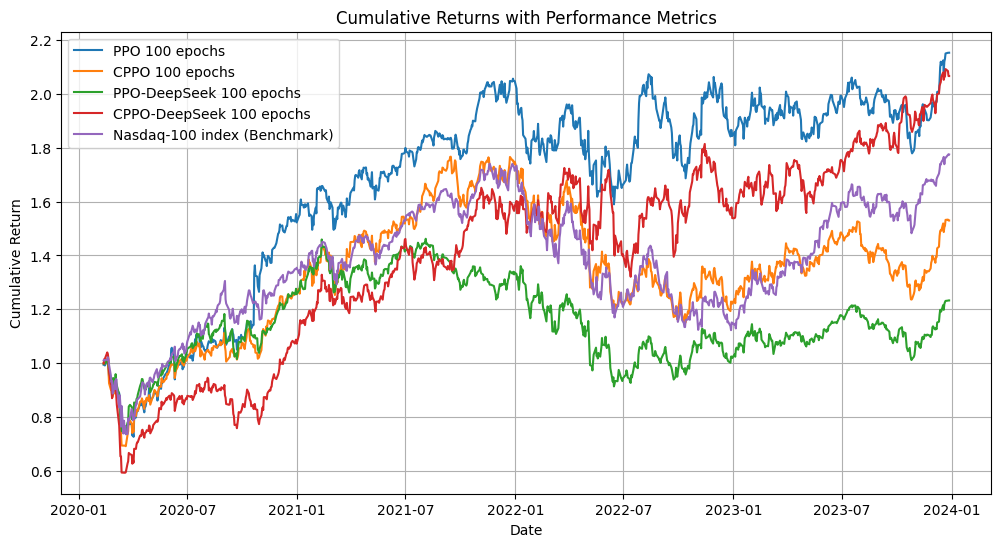

PPO 100 epochs Metrics:
  Information Ratio: 0.0077
  CVaR: -0.0360
  Rachev Ratio: 1.1377
CPPO 100 epochs Metrics:
  Information Ratio: -0.0061
  CVaR: -0.0399
  Rachev Ratio: 0.9761
PPO-DeepSeek 100 epochs Metrics:
  Information Ratio: -0.0173
  CVaR: -0.0371
  Rachev Ratio: 1.0165
CPPO-DeepSeek 100 epochs Metrics:
  Information Ratio: 0.0070
  CVaR: -0.0443
  Rachev Ratio: 0.9341


In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Utility Functions
def calculate_metric(returns_strategy, returns_benchmark, confidence_level=0.05, upside_confidence=0.95):
    """Calculate performance metrics: IR, CVaR, and Rachev Ratio."""
    excess_return = returns_strategy - returns_benchmark
    ir = excess_return.mean() / excess_return.std()
    var = np.percentile(returns_strategy, confidence_level * 100)
    cvar = returns_strategy[returns_strategy <= var].mean()
    upside_var = np.percentile(returns_strategy, upside_confidence * 100)
    downside_var = var
    rachev_ratio = returns_strategy[returns_strategy >= upside_var].mean() / abs(returns_strategy[returns_strategy <= downside_var].mean())
    return {"Information Ratio": ir, "CVaR": cvar, "Rachev Ratio": rachev_ratio}

def align_returns(result, col_strategy, col_benchmark):
    """Align returns for strategy and benchmark."""
    returns_strategy = result[col_strategy].pct_change().dropna()
    returns_benchmark = result[col_benchmark].pct_change().dropna()
    return returns_strategy.align(returns_benchmark, join="inner")

# Metrics Calculation
def compute_metrics(result, strategies, benchmark, confidence_level=0.05, upside_confidence=0.95):
    """
    Compute metrics for multiple strategies compared to a benchmark.

    Parameters:
        result (pd.DataFrame): DataFrame with strategies and benchmark columns.
        strategies (list): List of strategy column names.
        benchmark (str): Benchmark column name.
        confidence_level (float): Confidence level for CVaR calculation.
        upside_confidence (float): Confidence level for upside in Rachev Ratio.

    Returns:
        dict: Performance metrics for each strategy.
    """
    metrics = {}
    for strategy in strategies:
        aligned_strategy, aligned_benchmark = align_returns(result, strategy, benchmark)
        metrics[strategy] = calculate_metric(
            aligned_strategy, aligned_benchmark, confidence_level, upside_confidence
        )
    return metrics

# Plotting
def plot_cumulative_returns(result, metrics, strategies, benchmark):
    """
    Plot cumulative returns for strategies and benchmark with annotated metrics.

    Parameters:
        result (pd.DataFrame): DataFrame with strategies and benchmark.
        metrics (dict): Performance metrics.
        strategies (list): List of strategy column names.
        benchmark (str): Benchmark column name.
    """
    plt.figure(figsize=(12, 6))
    for strategy in strategies:
        cumulative_returns = (1 + result[strategy].pct_change().dropna()).cumprod()
        plt.plot(cumulative_returns, label=f"{strategy}")
    cumulative_benchmark = (1 + result[benchmark].pct_change().dropna()).cumprod()
    plt.plot(cumulative_benchmark, label=f"{benchmark} (Benchmark)")
    plt.title("Cumulative Returns with Performance Metrics")
    plt.legend()
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.grid()
    plt.show()

# Example Usage
# Assuming `result` DataFrame is prepared with "PPO 25 epochs", "CPPO 25 epochs", and "Nasdaq-100 index"
strategies = [
"PPO 100 epochs",
"CPPO 100 epochs",
"PPO-DeepSeek 100 epochs",
#"PPO-Llama 100 epochs",
"CPPO-DeepSeek 100 epochs"
#"CPPO-Llama 100 epochs",
]
#strategies = ["PPO 20 epochs", "CPPO 20 epochs", "CPPO-DeepSeek 20 epochs"]
benchmark = "Nasdaq-100 index"
metrics = compute_metrics(result, strategies, benchmark)
plot_cumulative_returns(result, metrics, strategies, benchmark)

# Print metrics
for strategy, strategy_metrics in metrics.items():
    print(f"{strategy} Metrics:")
    for metric_name, value in strategy_metrics.items():
        print(f"  {metric_name}: {value:.4f}")

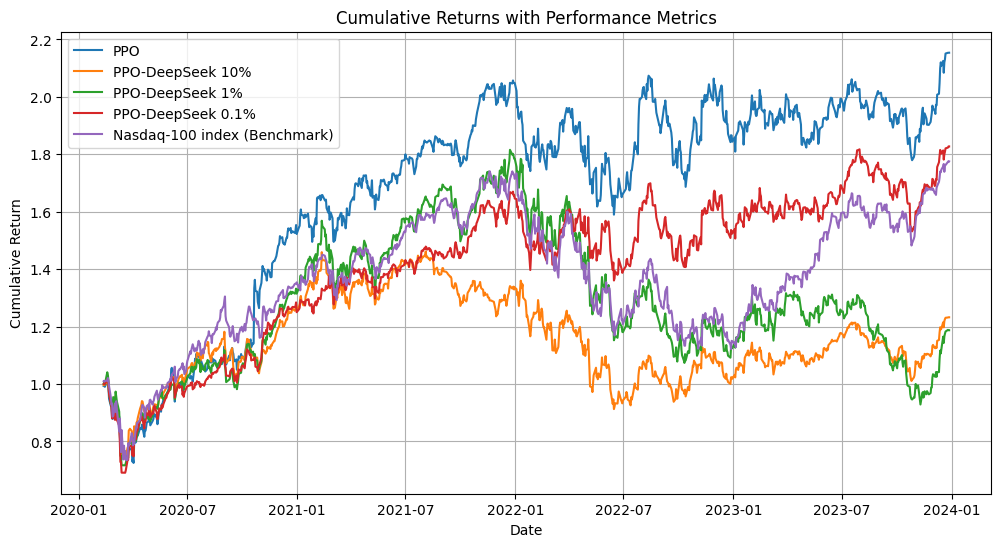

PPO Metrics:
  Information Ratio: 0.0077
  CVaR: -0.0360
  Rachev Ratio: 1.1377
PPO-DeepSeek 10% Metrics:
  Information Ratio: -0.0173
  CVaR: -0.0371
  Rachev Ratio: 1.0165
PPO-DeepSeek 1% Metrics:
  Information Ratio: -0.0158
  CVaR: -0.0421
  Rachev Ratio: 1.0051
PPO-DeepSeek 0.1% Metrics:
  Information Ratio: -0.0005
  CVaR: -0.0350
  Rachev Ratio: 0.9557


In [81]:
# Example Usage
# Assuming `result` DataFrame is prepared with "PPO 25 epochs", "CPPO 25 epochs", and "Nasdaq-100 index"
strategies = ["PPO", "PPO-DeepSeek 10%", "PPO-DeepSeek 1%", "PPO-DeepSeek 0.1%"]
#"CPPO-Llama 100 epochs"]
#strategies = ["PPO", "CPPO 25 epochs", "CPPO-DeepSeek 20 epochs"]
benchmark = "Nasdaq-100 index"
metrics = compute_metrics(result_ppo, strategies, benchmark)
plot_cumulative_returns(result_ppo, metrics, strategies, benchmark)

# Print metrics
for strategy, strategy_metrics in metrics.items():
    print(f"{strategy} Metrics:")
    for metric_name, value in strategy_metrics.items():
        print(f"  {metric_name}: {value:.4f}")

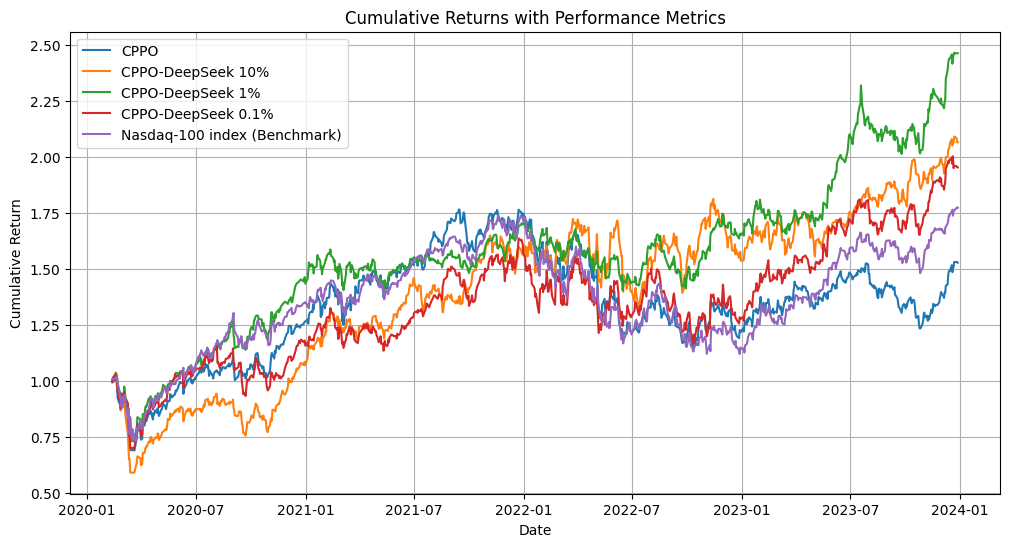

CPPO Metrics:
  Information Ratio: -0.0061
  CVaR: -0.0399
  Rachev Ratio: 0.9761
CPPO-DeepSeek 10% Metrics:
  Information Ratio: 0.0070
  CVaR: -0.0443
  Rachev Ratio: 0.9341
CPPO-DeepSeek 1% Metrics:
  Information Ratio: 0.0127
  CVaR: -0.0329
  Rachev Ratio: 1.0350
CPPO-DeepSeek 0.1% Metrics:
  Information Ratio: 0.0046
  CVaR: -0.0439
  Rachev Ratio: 0.9641


In [82]:
# Example Usage
# Assuming `result` DataFrame is prepared with "PPO 25 epochs", "CPPO 25 epochs", and "Nasdaq-100 index"
strategies = [
"CPPO",
"CPPO-DeepSeek 10%",
"CPPO-DeepSeek 1%",
"CPPO-DeepSeek 0.1%",
#"CPPO-Llama 100 epochs",
]
#strategies = ["PPO 20 epochs", "CPPO 20 epochs", "CPPO-DeepSeek 20 epochs"]
benchmark = "Nasdaq-100 index"
metrics = compute_metrics(result_cppo, strategies, benchmark)
plot_cumulative_returns(result_cppo, metrics, strategies, benchmark)

# Print metrics
for strategy, strategy_metrics in metrics.items():
    print(f"{strategy} Metrics:")
    for metric_name, value in strategy_metrics.items():
        print(f"  {metric_name}: {value:.4f}")

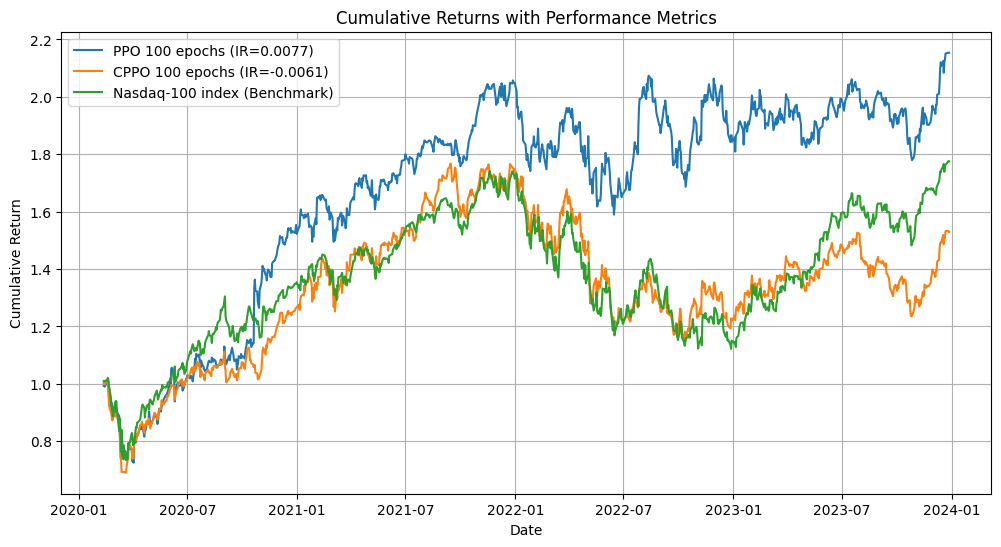

PPO Metrics:
  Information Ratio: 0.0077
  CVaR: -0.0360
  Rachev Ratio: 1.1377
CPPO Metrics:
  Information Ratio: -0.0061
  CVaR: -0.0399
  Rachev Ratio: 0.9761


In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

def calculate_information_ratio(returns_strategy, returns_benchmark):
    """Calculate the Information Ratio (IR)."""
    excess_return = returns_strategy - returns_benchmark
    return excess_return.mean() / excess_return.std()

def calculate_cvar(returns_strategy, confidence_level=0.05):
    """Calculate the Conditional Value at Risk (CVaR)."""
    var = np.percentile(returns_strategy, confidence_level * 100)
    return returns_strategy[returns_strategy <= var].mean()

def calculate_rachev_ratio(returns_strategy, upside_confidence=0.95, downside_confidence=0.05):
    """Calculate the Rachev Ratio."""
    upside_var = np.percentile(returns_strategy, upside_confidence * 100)
    downside_var = np.percentile(returns_strategy, downside_confidence * 100)
    upside_mean = returns_strategy[returns_strategy >= upside_var].mean()
    downside_mean = abs(returns_strategy[returns_strategy <= downside_var].mean())
    return upside_mean / downside_mean

def align_and_compute_metrics(result, confidence_level=0.05, upside_confidence=0.95):
    """
    Align data for PPO, CPPO, and benchmark, and compute performance metrics.

    Parameters:
        result (pd.DataFrame): DataFrame with strategies and benchmark.
        confidence_level (float): Confidence level for CVaR calculation.
        upside_confidence (float): Confidence level for upside in Rachev Ratio.

    Returns:
        dict: Performance metrics for PPO and CPPO.
    """
    # Calculate returns
    returns_ppo = result["PPO 100 epochs"].pct_change().dropna()
    returns_cppo = result["CPPO 100 epochs"].pct_change().dropna()
    returns_benchmark = result["Nasdaq-100 index"].pct_change().dropna()

    # Align returns
    returns_ppo, returns_benchmark_ppo = returns_ppo.align(returns_benchmark, join="inner")
    returns_cppo, returns_benchmark_cppo = returns_cppo.align(returns_benchmark, join="inner")

    # Compute metrics
    metrics = {
        "PPO": {
            "Information Ratio": calculate_information_ratio(returns_ppo, returns_benchmark_ppo),
            "CVaR": calculate_cvar(returns_ppo, confidence_level),
            "Rachev Ratio": calculate_rachev_ratio(returns_ppo, upside_confidence, confidence_level),
        },
        "CPPO": {
            "Information Ratio": calculate_information_ratio(returns_cppo, returns_benchmark_cppo),
            "CVaR": calculate_cvar(returns_cppo, confidence_level),
            "Rachev Ratio": calculate_rachev_ratio(returns_cppo, upside_confidence, confidence_level),
        }
    }
    return metrics

def plot_cumulative_returns(result, metrics):
    """
    Plot cumulative returns for PPO, CPPO, and benchmark with annotated metrics.

    Parameters:
        result (pd.DataFrame): DataFrame with strategies and benchmark.
        metrics (dict): Performance metrics.
    """
    # Calculate cumulative returns
    cumulative_ppo = (1 + result["PPO 100 epochs"].pct_change().dropna()).cumprod()
    cumulative_cppo = (1 + result["CPPO 100 epochs"].pct_change().dropna()).cumprod()
    cumulative_benchmark = (1 + result["Nasdaq-100 index"].pct_change().dropna()).cumprod()

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(cumulative_ppo, label=f"PPO 100 epochs (IR={metrics['PPO']['Information Ratio']:.4f})")
    plt.plot(cumulative_cppo, label=f"CPPO 100 epochs (IR={metrics['CPPO']['Information Ratio']:.4f})")
    plt.plot(cumulative_benchmark, label="Nasdaq-100 index (Benchmark)")
    plt.title("Cumulative Returns with Performance Metrics")
    plt.legend()
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.grid()
    plt.show()

# Example Usage
# Assuming `result` DataFrame is prepared with "PPO 100 epochs", "CPPO 100 epochs", and "Nasdaq-100 index"
metrics = align_and_compute_metrics(result)
plot_cumulative_returns(result, metrics)

# Print metrics
for strategy, strategy_metrics in metrics.items():
    print(f"{strategy} Metrics:")
    for metric_name, value in strategy_metrics.items():
        print(f"  {metric_name}: {value:.4f}")

In [84]:
import pandas as pd
import matplotlib.pyplot as plt

# ... (your existing code to load data and calculate strategies) ...

# Get unique trading dates from your trade data
trade_dates = pd.to_datetime(trade['date'].unique())

first_date = trade_dates[0]
date_before_first = first_date - pd.DateOffset(days=1)

# Prepend the date before the first date to trade_dates
trade_dates = pd.DatetimeIndex([date_before_first] + trade_dates.tolist())


# Reindex your strategy results to match the trading dates
df_assets_ppo_series = pd.Series(df_assets_ppo, index=trade_dates)
df_assets_cppo_series = pd.Series(df_assets_cppo, index=trade_dates) # Convert to Series
#df_dji_normalized_close_series = pd.Series(df_dji_normalized_close, index=trade_dates) # Convert to Series


# 1. Get dates from df_dji (Yahoo Finance data)

dji_dates = pd.to_datetime(df_dji['date'])

# 2. Find the intersection of trade_dates and dji_dates
common_dates = trade_dates.intersection(dji_dates)

# 3. Reindex df_assets_ppo to keep only common_dates
df_assets_ppo_series = pd.Series(df_assets_ppo, index=trade_dates).reindex(common_dates)
df_assets_cppo_series = pd.Series(df_assets_cppo, index=trade_dates).reindex(common_dates)

# Reindex df_dji to match common_dates, forward-filling missing values (if any)
df_assets_ppo_series = pd.Series(df_assets_ppo[:len(common_dates)], index=common_dates)
df_assets_cppo_series = pd.Series(df_assets_cppo[:len(common_dates)], index=common_dates)
df_dji_normalized_close_series = pd.Series(df_dji_normalized_close[:len(common_dates)], index=common_dates)
# Create the DataFrame with trading dates as the index
result = pd.DataFrame(
    {
        "PPO 100 epochs": df_assets_ppo_series,
        "CPPO 100 epochs": df_assets_cppo_series,
        "Nasdaq-100 index": df_dji_normalized_close_series,
    }
)

In [85]:
result.to_csv('result_ppo_100_epochs_20k_steps.csv')

Sharpe Ratio (PPO): 1.0797
Sharpe Ratio (CPPO): 0.8852
Information Ratio (PPO): 0.0154
Information Ratio (CPPO): 0.0082
cvar (PPO) (5%): -0.0375
cvar (CPPO) (5%): -0.0419
Rachev Ratio (PPO): 1.0528
Rachev Ratio (CPPO): 0.8770


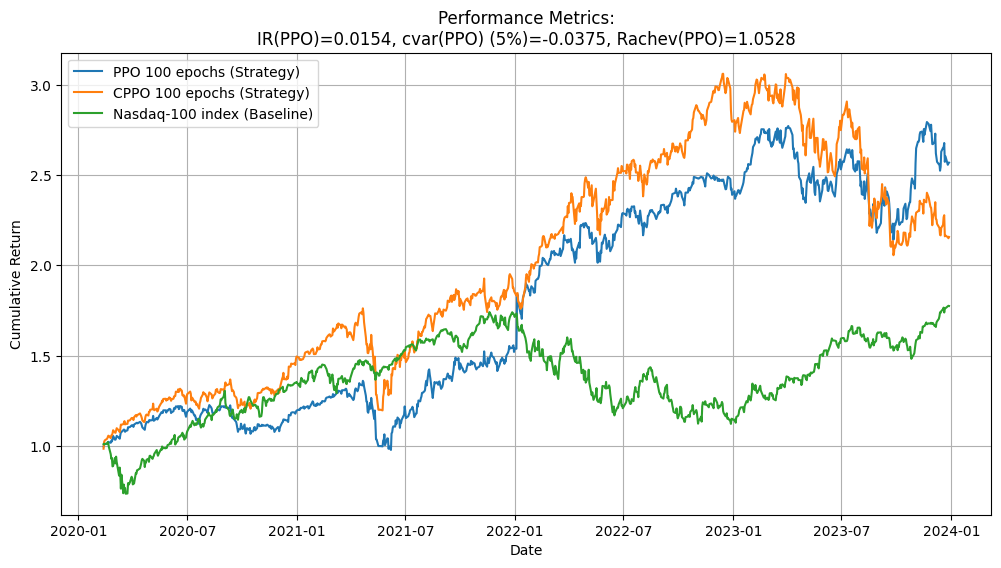

Cumulative Returns (PPO):
2023-12-21    2.574256
2023-12-22    2.605510
2023-12-26    2.557846
2023-12-27    2.565444
2023-12-28    2.569659
dtype: float64
Cumulative Returns (CPPO):
2023-12-21    2.161380
2023-12-22    2.166268
2023-12-26    2.156509
2023-12-27    2.150898
2023-12-28    2.157973
dtype: float64
Cumulative Returns (Nasdaq-100 index):
2023-12-21    1.760628
2023-12-22    1.762728
2023-12-26    1.773346
2023-12-27    1.776324
2023-12-28    1.775448
dtype: float64


In [86]:
# prompt: plot also the sharpe ratio and sortino ratio of nasdaq and ppo

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming 'result' DataFrame is already created as in your provided code

# Calculate daily returns
result['PPO 100 epochs_daily_return'] = result['PPO 100 epochs'].pct_change()
result['CPPO 100 epochs_daily_return'] = result['CPPO 100 epochs'].pct_change()
result['Nasdaq-100 index_daily_return'] = result['Nasdaq-100 index'].pct_change()


# Calculate Sharpe Ratio
sharpe_ppo = np.sqrt(252) * (result['PPO 100 epochs_daily_return'].mean() / result['PPO 100 epochs_daily_return'].std())
sharpe_cppo = np.sqrt(252) * (result['CPPO 100 epochs_daily_return'].mean() / result['CPPO 100 epochs_daily_return'].std())
sharpe_nasdaq = np.sqrt(252) * (result['Nasdaq-100 index_daily_return'].mean() / result['Nasdaq-100 index_daily_return'].std())

# Calculate Sortino Ratio (assuming a target return of 0)
downside_returns_ppo = result['PPO 100 epochs_daily_return'].where(result['PPO 100 epochs_daily_return'] < 0, 0)
downside_returns_cppo = result['CPPO 100 epochs_daily_return'].where(result['CPPO 100 epochs_daily_return'] < 0, 0)
downside_returns_nasdaq = result['Nasdaq-100 index_daily_return'].where(result['Nasdaq-100 index_daily_return'] < 0, 0)

sortino_ppo = np.sqrt(252) * (result['PPO 100 epochs_daily_return'].mean() / downside_returns_ppo.std())
sortino_cppo = np.sqrt(252) * (result['CPPO 100 epochs_daily_return'].mean() / downside_returns_cppo.std())
sortino_nasdaq = np.sqrt(252) * (result['Nasdaq-100 index_daily_return'].mean() / downside_returns_nasdaq.std())

# Assuming `df_assets_ppo_series` and `df_dji_normalized_close_series` are already created
returns_strategy_ppo = df_assets_ppo_series.pct_change().dropna()
returns_strategy_cppo = df_assets_cppo_series.pct_change().dropna()
returns_benchmark = df_dji_normalized_close_series.pct_change().dropna()

# Align data
returns_strategy_ppo, returns_benchmark = returns_strategy_ppo.align(returns_benchmark, join="inner")
returns_strategy_cppo, returns_benchmark = returns_strategy_cppo.align(returns_benchmark, join="inner")

# Information Ratio
excess_return_ppo = returns_strategy_ppo - returns_benchmark
excess_return_cppo = returns_strategy_cppo - returns_benchmark
information_ratio_ppo = excess_return_ppo.mean() / excess_return_ppo.std()
information_ratio_cppo = (returns_strategy_cppo - returns_benchmark).mean() / (returns_strategy_cppo - returns_benchmark).std()

# cvar_ppo
confidence_level = 0.05
var_ppo = np.percentile(returns_strategy_ppo, confidence_level * 100)
var_cppo = np.percentile(returns_strategy_cppo, confidence_level * 100)
cvar_ppo = returns_strategy_ppo[returns_strategy_ppo <= var_ppo].mean()
cvar_cppo = returns_strategy_cppo[returns_strategy_cppo <= var_cppo].mean()

# Rachev Ratio PPO and CPPO
upside_confidence = 0.95
downside_confidence = 0.05
upside_var_ppo = np.percentile(returns_strategy_ppo, upside_confidence * 100)
upside_var_cppo = np.percentile(returns_strategy_cppo, upside_confidence * 100)
downside_var_ppo = np.percentile(returns_strategy_ppo, downside_confidence * 100)
downside_var_cppo = np.percentile(returns_strategy_cppo, downside_confidence * 100)
rachev_ratio_ppo = returns_strategy_ppo[returns_strategy_ppo >= upside_var_ppo].mean() / abs(returns_strategy_ppo[returns_strategy_ppo <= downside_var_ppo].mean())
rachev_ratio_cppo = returns_strategy_cppo[returns_strategy_cppo >= upside_var_cppo].mean() / abs(returns_strategy_cppo[returns_strategy_cppo <= downside_var_cppo].mean())



# Print metrics
print(f"Sharpe Ratio (PPO): {sharpe_ppo:.4f}")
print(f"Sharpe Ratio (CPPO): {sharpe_cppo:.4f}")
print(f"Information Ratio (PPO): {information_ratio_ppo:.4f}")
print(f"Information Ratio (CPPO): {information_ratio_cppo:.4f}")
print(f"cvar (PPO) (5%): {cvar_ppo:.4f}")
print(f"cvar (CPPO) (5%): {cvar_cppo:.4f}")
print(f"Rachev Ratio (PPO): {rachev_ratio_ppo:.4f}")
print(f"Rachev Ratio (CPPO): {rachev_ratio_cppo:.4f}")

# Plot
plt.figure(figsize=(12, 6))

# Strategy and benchmark cumulative returns
cumulative_strategy_ppo = (1 + returns_strategy_ppo).cumprod()
cumulative_strategy_cppo = (1 + returns_strategy_cppo).cumprod()
cumulative_benchmark = (1 + returns_benchmark).cumprod()

plt.plot(cumulative_strategy_ppo, label="PPO 100 epochs (Strategy)")
plt.plot(cumulative_strategy_cppo, label="CPPO 100 epochs (Strategy)")
plt.plot(cumulative_benchmark, label="Nasdaq-100 index (Baseline)")

# Add metrics to the plot
plt.title(f"Performance Metrics:\nIR(PPO)={information_ratio_ppo:.4f}, cvar(PPO) (5%)={cvar_ppo:.4f}, Rachev(PPO)={rachev_ratio_ppo:.4f}")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid()
plt.show()

# Print cumulative returns
print("Cumulative Returns (PPO):")
print(cumulative_strategy_ppo.tail())
print("Cumulative Returns (CPPO):")
print(cumulative_strategy_cppo.tail())
print("Cumulative Returns (Nasdaq-100 index):")
print(cumulative_benchmark.tail())


In [87]:
# Calculate the cumulative returns for each strategy
cumulative_ppo = (1 + result['PPO 100 epochs'].pct_change()).cumprod()
cumulative_cppo = (1 + result['CPPO 100 epochs'].pct_change()).cumprod()
cumulative_benchmark = (1 + result['Nasdaq-100 index'].pct_change()).cumprod()

# Print the cumulative returns
print("Cumulative Returns:")
print(f"PPO 100 epochs: {cumulative_ppo.iloc[-1]:.4f}")
print(f"CPPO 100 epochs: {cumulative_cppo.iloc[-1]:.4f}")
print(f"Nasdaq-100 index: {cumulative_benchmark.iloc[-1]:.4f}")

Cumulative Returns:
PPO 100 epochs: 2.5697
CPPO 100 epochs: 2.1580
Nasdaq-100 index: 1.7754


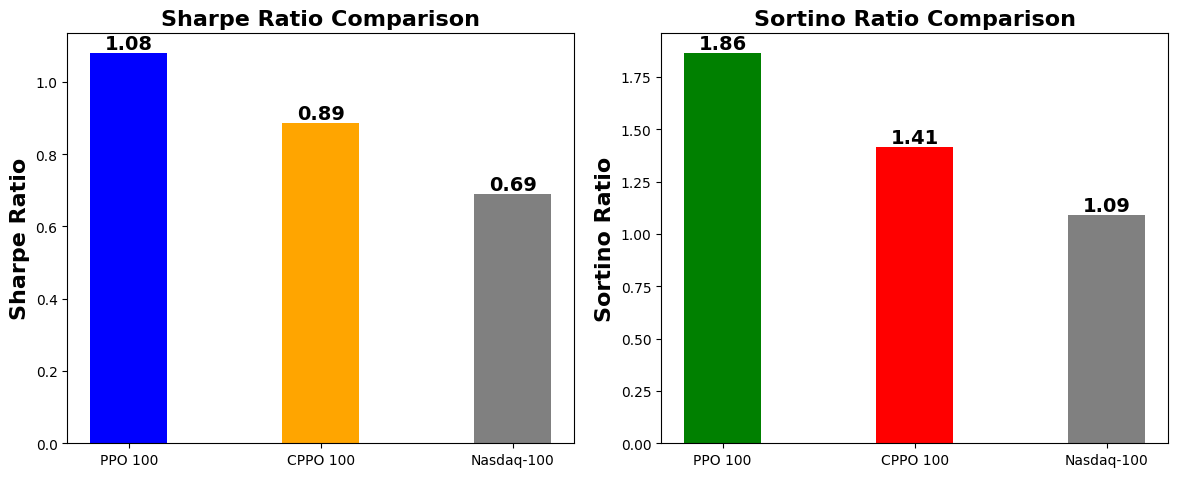

In [88]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

plt.rcParams.update({'font.size': 14})

# --- Subplot 1: Sharpe Ratio Comparison ---
bars1=ax1.bar(['PPO 100', 'CPPO 100', 'Nasdaq-100'], [sharpe_ppo, sharpe_cppo,sharpe_nasdaq], color=['blue', 'orange', 'gray'], width=0.4)
ax1.set_title('Sharpe Ratio Comparison', fontsize=16, fontweight='bold')
ax1.set_ylabel('Sharpe Ratio', fontsize=16, fontweight='bold')

for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height, f'{height:.2f}',
             ha='center', va='bottom', fontsize=14, fontweight='bold')



# --- Subplot 2: Sortino Ratio Comparison ---
bars2=ax2.bar(['PPO 100', 'CPPO 100', 'Nasdaq-100'], [sortino_ppo, sortino_cppo, sortino_nasdaq], color=['green', 'red', 'gray'], width=0.4)
ax2.set_title('Sortino Ratio Comparison', fontsize=16, fontweight='bold')
ax2.set_ylabel('Sortino Ratio', fontsize=16, fontweight='bold')

for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, height, f'{height:.2f}',
             ha='center', va='bottom', fontsize=14, fontweight='bold')


plt.tight_layout()
plt.show()

C:\Users\lishe\AppData\Local\Temp\ipykernel_19404\404702777.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tick_dates = result.index.to_series().resample('M').first().dropna()


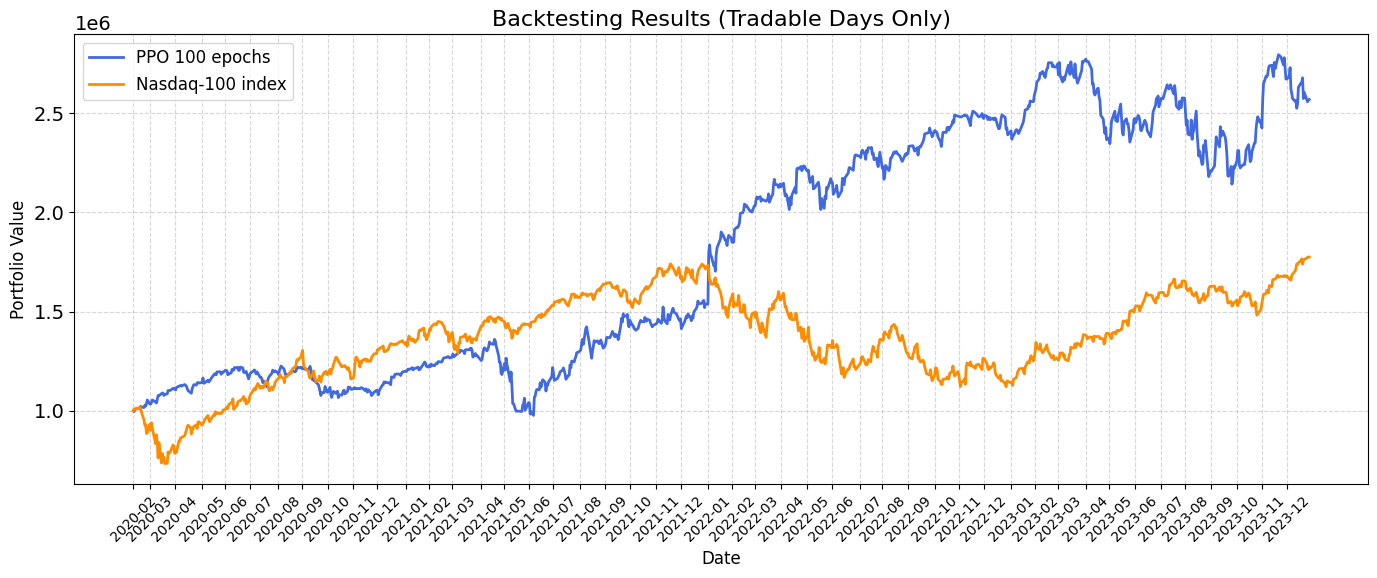

In [89]:
result = pd.DataFrame({
    "PPO 100 epochs": df_assets_ppo_series,
    "Nasdaq-100 index": df_dji_normalized_close_series
})

plt.figure(figsize=(14, 6))

# Plot the portfolio value and benchmark
plt.plot(result.index, result["PPO 100 epochs"], label="PPO 100 epochs", color="royalblue", linewidth=2)
plt.plot(result.index, result["Nasdaq-100 index"], label="Nasdaq-100 index", color="darkorange", linewidth=2)

# Title and labels
plt.title("Backtesting Results (Tradable Days Only)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Portfolio Value", fontsize=12)

# Set x-axis date labels
tick_dates = result.index.to_series().resample('M').first().dropna()
plt.xticks(ticks=tick_dates, labels=[d.strftime('%Y-%m') for d in tick_dates], rotation=45, fontsize=10)

# Add a legend
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()



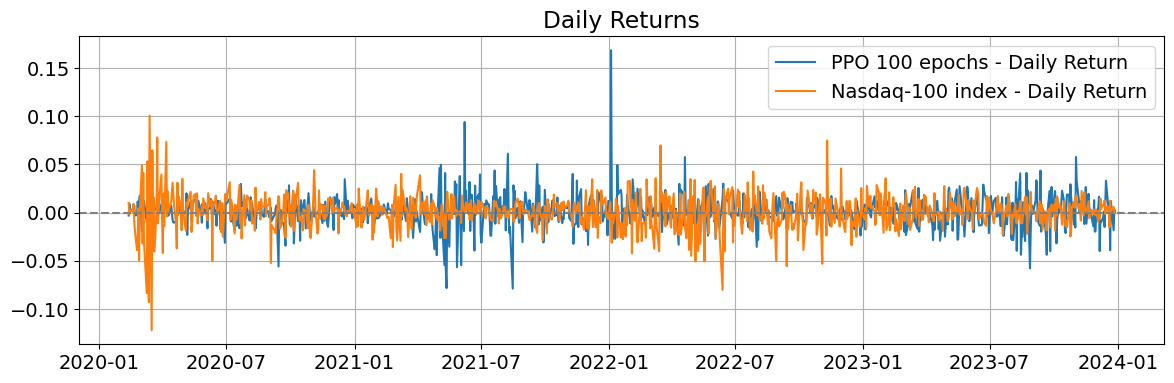

In [90]:
# Calculate daily returns (same as before)
returns_ppo = result["PPO 100 epochs"].pct_change()
returns_benchmark = result["Nasdaq-100 index"].pct_change()

plt.figure(figsize=(14, 4))
plt.plot(returns_ppo, label="PPO 100 epochs - Daily Return")
plt.plot(returns_benchmark, label="Nasdaq-100 index - Daily Return")
plt.axhline(0, color='gray', linestyle='--')
plt.title("Daily Returns")
plt.legend()
plt.grid()
plt.show()
